# Dyad Position Predictor
Train a neural network to predict dyad positions on a per-position basis from encoded DNA sequences (0-7).

## 1. Imports and setup
Load core libraries (NumPy, PyTorch, Matplotlib), utilities, and project helpers used throughout the notebook.

In [33]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from tqdm import tqdm
import json
from pathlib import Path
import os

from ChromatinFibers import simulate_chromatin_fibers, SimulationParams, SequencePlotter, read_simulation_results

## 2. Simulation parameters and output paths
Choose how many samples to simulate and define file paths for saving the model and generated data.

In [34]:
# Define simulation parameters and filename
simulation_params = SimulationParams(n_samples=100)

print("Simulation parameters:")
for key, value in simulation_params.__dict__.items():
    print(f"  {key}: {value}")

filename = rf"data/LLM models/test.pt"
plotter = SequencePlotter()

Simulation parameters:
  n_samples: 100
  length_bp: 10000
  amplitude: 0.05
  period_bp: 10.0
  chemical_potential_kT: 0.0
  e_contact_kT: -0.5
  motifs: ('A',)
  strand: both
  efficiency: 0.7
  steric_exclusion_bp: 0


In [35]:
# Generate the HDF5 data file - this returns the .h5 filename
h5_filename = simulate_chromatin_fibers(simulation_params, filename)
print(f"\nGenerated HDF5 file: {h5_filename}")

# Keep track of both: the HDF5 data file and the model file
data_filename = h5_filename
model_filename = Path(filename).with_suffix(".pt")
print(f"Model will be saved to: {model_filename}")

Save fibers in HDF5 file: data\LLM models\test.h5


Simulating fibers: 100%|██████████| 100/100 [02:45<00:00,  1.66s/it]


Generated HDF5 file: data\LLM models\test.h5
Model will be saved to: data\LLM models\test.pt


## 3. Model architecture visualization
Define and render a step-by-step diagram explaining how the model transforms an input sequence into per-position dyad probabilities.

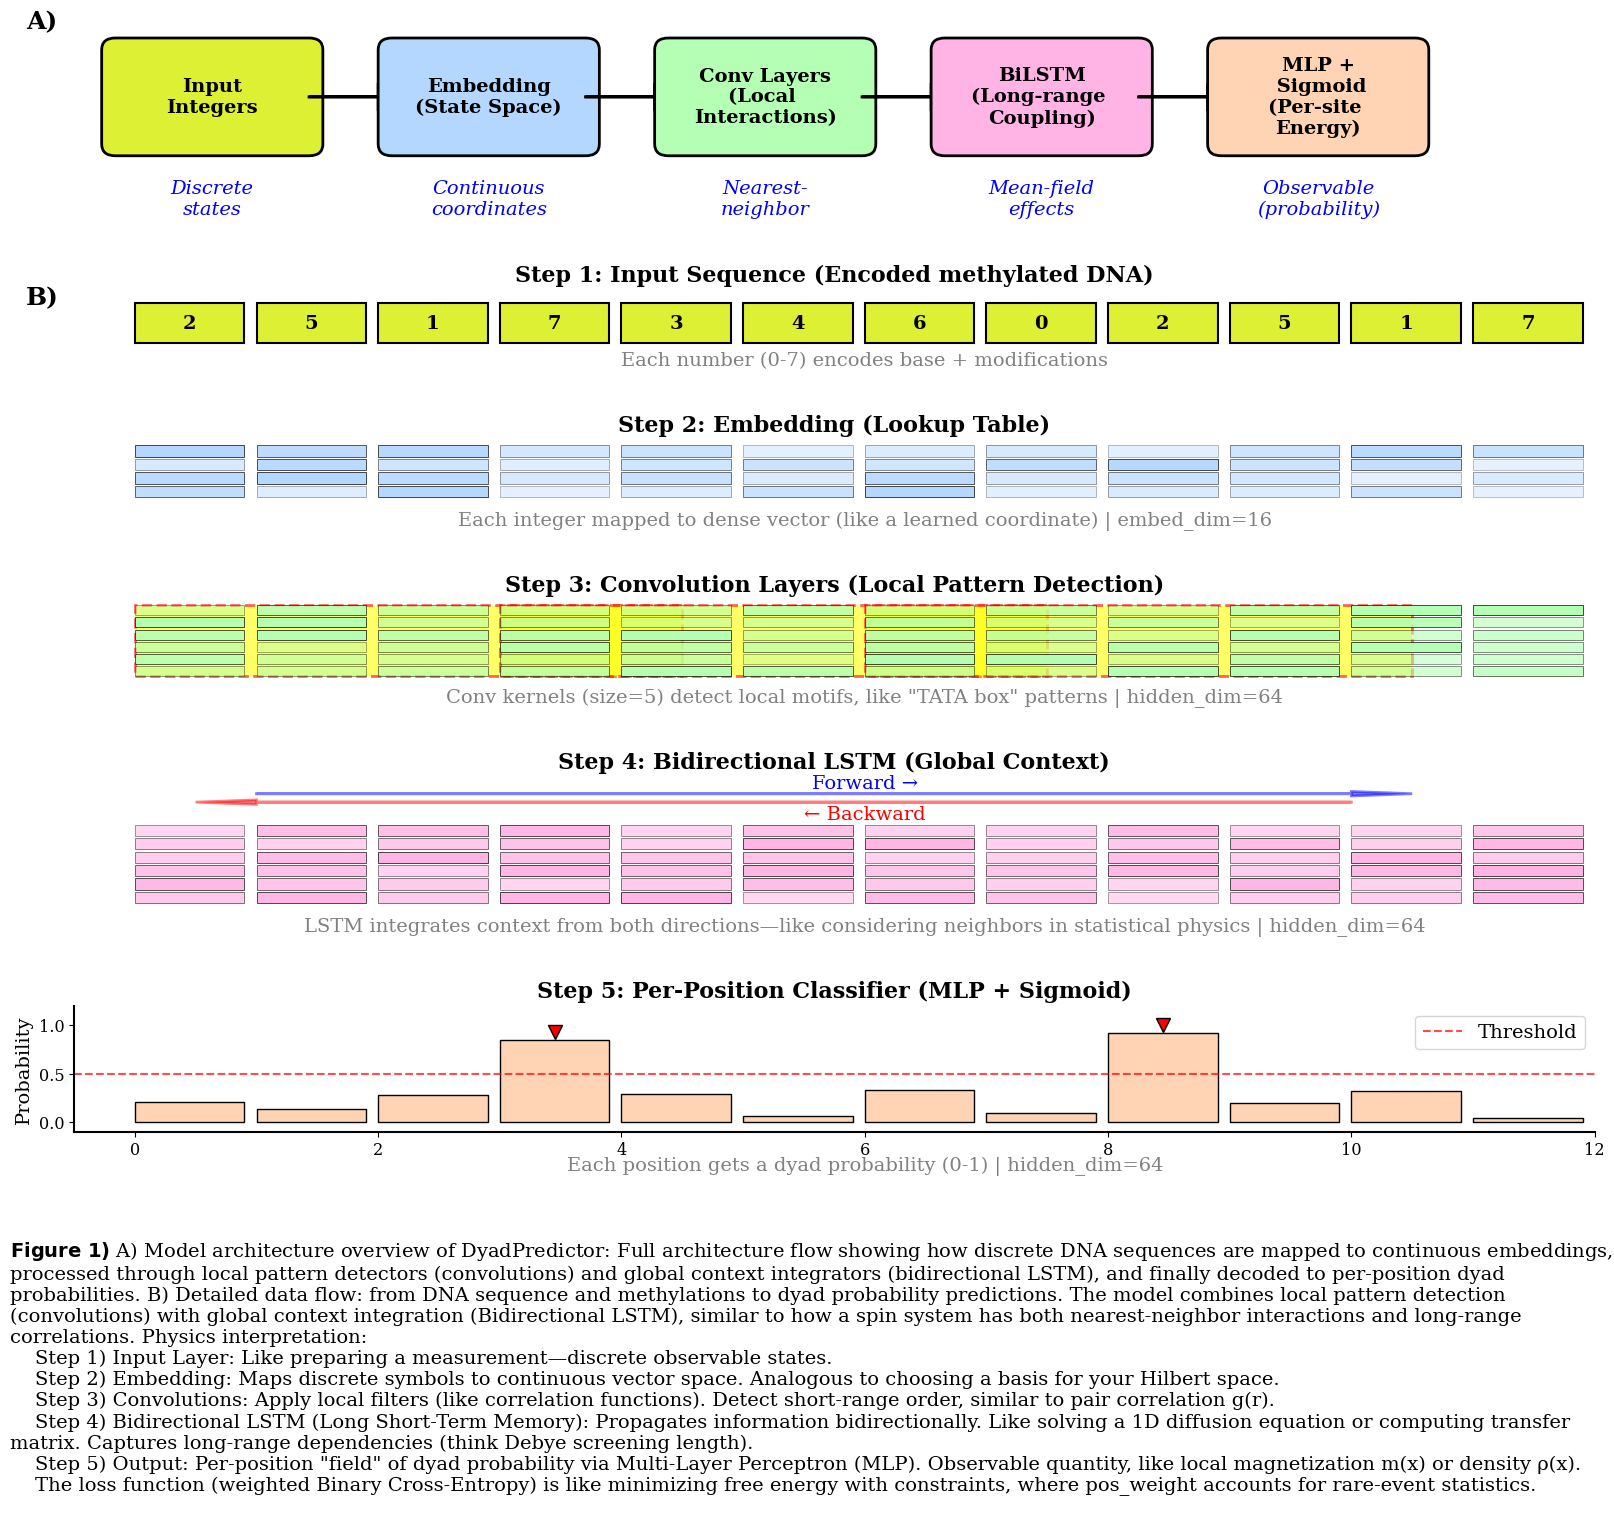

In [36]:
# Visualization of the LLM; diagram of data flow through the model
# not required for full operation

import matplotlib.patches as mpatches
from matplotlib.gridspec import GridSpec


def visualize_model_forward_pass(sequence_length=100):
    """
    Create a visual diagram showing how data flows through the model.
    Uses a toy example with shapes to illustrate transformations.
    """
    
    # Model hyperparameters (matching the actual model)
    embedding_dim = 16
    hidden_dim = 64

    # Shared box geometry for Steps 2–4
    BOX_HEIGHT = 0.20
    ROW_STEP = 0.24  # vertical step between rows
    
    # Use constrained_layout to avoid tight_layout warnings and improve spacing
    fig = plt.figure(figsize=(16, 12), constrained_layout=True)
    # Reorder: summary diagram at top (rows 0-1), then steps 1-5 (rows 2-7)
    gs = GridSpec(8, 3, figure=fig, height_ratios=[1.5, 1.5, 1, 1, 1.3, 2.1, 2, 0.2])
    # Increase vertical space between rows (steps)
    fig.set_constrained_layout_pads(w_pad=0.05, h_pad=0.05, hspace=0.3, wspace=0.2)
    
    # Define colors for different stages
    colors = {
        'input': "#DDF033",      # Light yellow
        'embed': '#B4D7FF',      # Light blue
        'conv': '#B4FFB4',       # Light green
        'lstm': '#FFB4E5',       # Light pink
        'output': '#FFD4B4'      # Light orange
    }
    
    # ========== Summary Diagram (NOW AT TOP) ==========
    ax_summary = fig.add_subplot(gs[0:2, :])
    fig.text(0.01, 1.0, 'A)', fontsize=18, fontweight='bold', va='top')
    ax_summary.axis('off')
    
    # Create flow diagram
    boxes = [
        ('Input\nIntegers', 0.5, colors['input']),
        ('Embedding\n(State Space)', 1.5, colors['embed']),
        ('Conv Layers\n(Local \nInteractions)', 2.5, colors['conv']),
        ('BiLSTM\n(Long-range \nCoupling)', 3.5, colors['lstm']),
        ('MLP +\n Sigmoid\n(Per-site \nEnergy)', 4.5, colors['output'])
    ]
    
    for label, x, color in boxes:
        rect = mpatches.FancyBboxPatch((x-0.35, 0.5), 0.7, 0.4, 
                                       boxstyle="round,pad=0.05", 
                                       facecolor=color, 
                                       edgecolor='black', linewidth=2)
        ax_summary.add_patch(rect)
        ax_summary.text(x, 0.7, label, ha='center', va='center', 
                fontsize=14, fontweight='bold')
        
        if x < 4.5:
            ax_summary.arrow(x+0.35, 0.7, 0.25, 0, head_width=0.1, head_length=0.08, 
                     fc='black', ec='black', linewidth=2)
    
    # Add physics analogies
    label_height = 0.35
    analogies = [
        (0.5, label_height, 'Discrete\nstates'),
        (1.5, label_height, 'Continuous\ncoordinates'),
        (2.5, label_height, 'Nearest-\nneighbor'),
        (3.5, label_height, 'Mean-field\neffects'),
        (4.5, label_height, 'Observable\n(probability)')
    ]
    
    for x, y, text in analogies:
        ax_summary.text(x, y, text, ha='center', va='top', 
                fontsize=14, style='italic', color='blue')
    
    ax_summary.set_xlim(0, 5.5)
    ax_summary.set_ylim(0.25, 1.05)
    
    # ========== 1. Input Sequence ==========
    ax1 = fig.add_subplot(gs[2, :])
    ax1.set_title('Step 1: Input Sequence (Encoded methylated DNA)', fontsize=16, fontweight='bold')
    fig.text(0.01, 0.77, 'B)', fontsize=18, fontweight='bold', va='top')
    
    # Show a small example sequence
    example_seq = [2, 5, 1, 7, 3, 4, 6, 0, 2, 5, 1, 7]
    n_show = len(example_seq)
    
    for i, val in enumerate(example_seq):
        rect = mpatches.Rectangle((i, 0), 0.9, 0.9, 
                                  facecolor=colors['input'], 
                                  edgecolor='black', linewidth=1.5)
        ax1.add_patch(rect)
        ax1.text(i + 0.45, 0.45, str(val), 
                ha='center', va='center', fontsize=14, fontweight='bold')
    
    ax1.set_xlim(-0.5, n_show)
    ax1.set_ylim(-0.2, 1.2)
    ax1.axis('off')
    ax1.text(n_show/2, -0.5, 'Each number (0-7) encodes base + modifications', 
            ha='center', fontsize=14, color='gray')
    
    # ========== 2. Embedding Layer ==========
    ax2 = fig.add_subplot(gs[3, :])
    ax2.set_title('Step 2: Embedding (Lookup Table)', fontsize=16, fontweight='bold')
    
    # Show embedding as small vertical bars (uniform height)
    embed_rows = 4
    for i in range(n_show):
        for j in range(embed_rows):  # Show 4 dimensions for visualization
            intensity = np.random.rand() * 0.7 + 0.3
            y0 = j * ROW_STEP
            rect = mpatches.Rectangle((i, y0), 0.9, BOX_HEIGHT, 
                                      facecolor=colors['embed'], 
                                      edgecolor='black', linewidth=0.5,
                                      alpha=intensity)
            ax2.add_patch(rect)
    
    ax2.set_xlim(-0.5, n_show)
    ax2.set_ylim(-0.1, ROW_STEP*(embed_rows-1) + BOX_HEIGHT + 0.1)
    ax2.axis('off')
    ax2.text(n_show/2, -0.5, f'Each integer mapped to dense vector (like a learned coordinate) | embed_dim={embedding_dim}', 
            ha='center', fontsize=14, color='gray')
    
    # ========== 3. Conv Layer 1 ==========
    ax3 = fig.add_subplot(gs[4, :])
    ax3.set_title('Step 3: Convolution Layers (Local Pattern Detection)', 
                 fontsize=16, fontweight='bold')
    
    # Show convolution as sliding windows
    kernel_size = 5
    conv_rows = 6
    y_max3 = ROW_STEP*(conv_rows-1) + BOX_HEIGHT
    for i in range(n_show - kernel_size + 1):
        # Highlight receptive field
        if i % 3 == 0:  # Show every 3rd for clarity
            rect_bg = mpatches.Rectangle((i, 0), kernel_size*0.9, y_max3, 
                                         facecolor='yellow', alpha=0.6, 
                                         edgecolor='red', linewidth=2, linestyle='--')
            ax3.add_patch(rect_bg)
    
    for i in range(n_show):
        for j in range(conv_rows):
            intensity = np.random.rand() * 0.6 + 0.4
            y0 = j * ROW_STEP
            rect = mpatches.Rectangle((i, y0), 0.9, BOX_HEIGHT, 
                                      facecolor=colors['conv'], 
                                      edgecolor='black', linewidth=0.5,
                                      alpha=intensity)
            ax3.add_patch(rect)
    
    ax3.set_xlim(-0.5, n_show)
    ax3.set_ylim(-0.1, y_max3 + 0.1)
    ax3.axis('off')
    ax3.text(n_show/2, -0.5, f'Conv kernels (size=5) detect local motifs, like "TATA box" patterns | hidden_dim={hidden_dim}', 
            ha='center', fontsize=14, color='gray')
    
    # ========== 4. BiLSTM Layer ==========
    ax4 = fig.add_subplot(gs[5, :])
    ax4.set_title('Step 4: Bidirectional LSTM (Global Context)', 
                 fontsize=16, fontweight='bold')
    
    lstm_rows = 6
    y_max4 = ROW_STEP*(lstm_rows-1) + BOX_HEIGHT*4
    # Show information flow with arrows
    for i in range(n_show):
        for j in range(lstm_rows):
            intensity = np.random.rand() * 0.5 + 0.5
            y0 = j * ROW_STEP
            rect = mpatches.Rectangle((i, y0), 0.9, BOX_HEIGHT, 
                                      facecolor=colors['lstm'], 
                                      edgecolor='black', linewidth=0.5,
                                      alpha=intensity)
            ax4.add_patch(rect)
    
    # Draw arrows showing bidirectional flow (positioned near the top of the band)
    arrow_y = max(0.15, y_max4 - 0.05)
    ax4.arrow(1, arrow_y, n_show-3, 0, head_width=0.08, head_length=0.5, 
             fc='blue', ec='blue', alpha=0.5, linewidth=2)
    ax4.arrow(n_show-2, arrow_y-0.15, -(n_show-3), 0, head_width=0.08, head_length=0.5, 
             fc='red', ec='red', alpha=0.5, linewidth=2)
    
    ax4.text(n_show/2, arrow_y+0.1, 'Forward →', ha='center', fontsize=14, color='blue')
    ax4.text(n_show/2, arrow_y-0.45, '← Backward', ha='center', fontsize=14, color='red')
    
    ax4.set_xlim(-0.5, n_show)
    ax4.set_ylim(-0.1, y_max4 + 0.25)
    ax4.axis('off')
    ax4.text(n_show/2, -0.5, f'LSTM integrates context from both directions—like considering neighbors in statistical physics | hidden_dim={hidden_dim}', 
            ha='center', fontsize=14, color='gray')
    
    # ========== 5. Output Layer ==========
    ax5 = fig.add_subplot(gs[6, :])
    ax5.set_title('Step 5: Per-Position Classifier (MLP + Sigmoid)', 
                 fontsize=16, fontweight='bold')
    
    # Show output as probability bars
    np.random.seed(42)
    probs = np.random.beta(2, 10, n_show)  # Skewed distribution (most low, few high)
    probs[[3, 8]] = [0.85, 0.92]  # Make two positions "dyads"
    
    for i in range(n_show):
        # Probability bar
        rect = mpatches.Rectangle((i, 0), 0.9, probs[i], 
                                  facecolor=colors['output'], 
                                  edgecolor='black', linewidth=1)
        ax5.add_patch(rect)
        
        # Mark high-confidence predictions
        if probs[i] > 0.5:
            ax5.plot(i + 0.45, probs[i] + 0.08, 'v', 
                    color='red', markersize=10, markeredgecolor='black')
    
    ax5.axhline(y=0.5, color='red', linestyle='--', linewidth=1.5, alpha=0.7, label='Threshold')
    ax5.set_xlim(-0.5, n_show)
    ax5.set_ylim(-0.1, 1.2)
    ax5.set_ylabel('Probability', fontsize=14)
    ax5.spines['top'].set_visible(False)
    ax5.spines['right'].set_visible(False)
    ax5.spines['left'].set_linewidth(1.5)
    ax5.spines['bottom'].set_linewidth(1.5)
    ax5.text(n_show/2, -0.5, f'Each position gets a dyad probability (0-1) | hidden_dim={hidden_dim}', 
            ha='center', fontsize=14, color='gray')
    ax5.legend(loc='upper right', fontsize=14)
    
    caption = "A) Model architecture overview of DyadPredictor: Full architecture flow showing how discrete DNA sequences are mapped to continuous embeddings, processed through local pattern detectors (convolutions) and global context integrators (bidirectional LSTM), and finally decoded to per-position dyad probabilities. B) Detailed data flow: from DNA sequence and methylations to dyad probability predictions. "
    caption += "The model combines local pattern detection (convolutions) with global context integration (Bidirectional LSTM), "
    caption += "similar to how a spin system has both nearest-neighbor interactions and long-range correlations. Physics interpretation: "
    caption += """
    Step 1) Input Layer: Like preparing a measurement—discrete observable states.
    Step 2) Embedding: Maps discrete symbols to continuous vector space. Analogous to choosing a basis for your Hilbert space.
    Step 3) Convolutions: Apply local filters (like correlation functions). Detect short-range order, similar to pair correlation g(r).
    Step 4) Bidirectional LSTM (Long Short-Term Memory): Propagates information bidirectionally. Like solving a 1D diffusion equation or computing transfer matrix. Captures long-range dependencies (think Debye screening length).
    Step 5) Output: Per-position "field" of dyad probability via Multi-Layer Perceptron (MLP). Observable quantity, like local magnetization m(x) or density ρ(x).
    The loss function (weighted Binary Cross-Entropy) is like minimizing free energy with constraints, where pos_weight accounts for rare-event statistics.
    """

    plotter.add_caption(caption)

    return fig

# Create the visualization
fig = visualize_model_forward_pass(sequence_length=100)

## 4. Verify data file exists
Check that the HDF5 data file exists from the simulation in the previous cell. Load simulation parameters from the file.

In [ ]:
# Set number of smaples for training
max_samples_to_use = 10

# Verify HDF5 data file exists and load parameters
if Path(data_filename).exists():
    print(f"Data file verified: {data_filename}")
    
    # Load simulation parameters from HDF5 file
    loaded_params = read_simulation_results(data_filename)
    print("\nLoaded simulation parameters:")
    for key, value in loaded_params.__dict__.items():
        print(f"  {key}: {value}")
    
    # Write simulation parameters to JSON config for reference
    config_path = model_filename.with_suffix(".json")
    
    if config_path.exists():
        with open(config_path, "r") as f:
            existing_config = json.load(f)
    else:
        existing_config = {}
    
    existing_config["simulation"] = loaded_params.__dict__
    
    with open(config_path, "w") as f:
        json.dump(existing_config, f, indent=4)
    
    print(f"\nConfig saved to: {config_path}")
else:
    raise FileNotFoundError(f"Data file not found: {data_filename}. Run the simulation cell first.")

Data file verified: data\LLM models\test.h5

Loaded simulation parameters:
  n_samples: 108
  length_bp: 10000
  amplitude: 0.05
  period_bp: 10.0
  chemical_potential_kT: 0.0
  e_contact_kT: -0.5
  motifs: ['A']
  strand: both
  efficiency: 0.7
  steric_exclusion_bp: 0

Config saved to: data\LLM models\test.json


## 5. Define model architecture (PyTorch)
Build the DyadPredictor network: embedding, convolutional blocks for local motifs, BiLSTM for context, and a per-position classifier.

In [38]:
class DyadPredictor(nn.Module):
    """Per-position dyad predictor using Conv1d and bidirectional context."""

    def __init__(
        self, vocab_size=8, embedding_dim=16, hidden_dim=64, num_layers=2, dropout=0.3
    ):
        super().__init__()
        self.vocab_size = vocab_size

        # Embedding layer (map 0-7 to dense vectors)
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        # Conv blocks for local context
        self.conv1 = nn.Conv1d(embedding_dim, hidden_dim, kernel_size=5, padding=2)
        self.conv2 = nn.Conv1d(hidden_dim, hidden_dim, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)

        # BiLSTM for global context
        self.lstm = nn.LSTM(
            hidden_dim,
            hidden_dim // 2,
            num_layers=num_layers,
            bidirectional=True,
            dropout=dropout if num_layers > 1 else 0,
            batch_first=True,
        )

        # Output head
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim // 2, 1),
        )

    def forward(self, x):
        """Forward pass.
        Args:
            x: (batch_size, seq_len) - encoded sequence
        Returns:
            logits: (batch_size, seq_len, 1) - per-position dyad logits
        """
        # Embedding: (batch, seq_len) -> (batch, seq_len, embed_dim)
        x = self.embedding(x)

        # Conv blocks: (batch, seq_len, embed_dim) -> (batch, embed_dim, seq_len)
        x = x.transpose(1, 2)
        x = self.conv1(x)
        x = self.bn1(x)
        x = torch.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = torch.relu(x)

        # Back to (batch, seq_len, hidden_dim)
        x = x.transpose(1, 2)

        # LSTM: (batch, seq_len, hidden_dim) -> (batch, seq_len, hidden_dim)
        x, _ = self.lstm(x)

        # Per-position classification: (batch, seq_len, hidden_dim) -> (batch, seq_len, 1)
        logits = self.fc(x)

        return logits

## 6. Define custom Dataset (HDF5-based)
Implement a Dataset that loads samples on-demand from the HDF5 file using read_simulation_results, pads sequences, and marks padding with -1 in labels.

In [39]:
class DyadDataset(Dataset):
    """HDF5-based dataset for dyad position prediction - loads data on-demand from disk."""

    def __init__(self, data_filename, indices=None, max_seq_len=None):
        """
        Args:
            data_filename: path to .h5 file containing dyad positions and encoded sequences
            indices: list of sample indices to use (for train/val/test split)
            max_seq_len: optional, pad/truncate sequences to this length
        """
        self.data_filename = data_filename
        self.indices = indices

        # Load metadata from HDF5 to determine dataset size and max_seq_len
        params = read_simulation_results(data_filename)
        self.n_total_samples = params.n_samples

        # Use the known sequence length from simulation parameters
        if max_seq_len is None:
            self.max_seq_len = params.length_bp
        else:
            self.max_seq_len = max_seq_len

        # Default to all samples if no indices provided
        if self.indices is None:
            self.indices = list(range(self.n_total_samples))

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        # Map dataset index to actual file index
        real_idx = self.indices[idx]

        # Load only the requested sample from HDF5
        dyad_pos, encoded_seq, _ = read_simulation_results(self.data_filename, real_idx)

        # Convert to regular numpy arrays
        dyad_pos = np.asarray(dyad_pos, dtype=np.int64)
        encoded_seq = np.asarray(encoded_seq, dtype=np.int64)

        seq_len = len(encoded_seq)

        # Create binary label: 1 if dyad at position, 0 otherwise
        label = np.zeros(seq_len, dtype=np.float32)
        for pos in dyad_pos:
            if 0 <= pos < seq_len:
                label[pos] = 1.0

        # Convert to tensors
        seq_tensor = torch.LongTensor(encoded_seq)
        label_tensor = torch.FloatTensor(label)

        # Pad/truncate to max_seq_len
        if seq_len < self.max_seq_len:
            pad_len = self.max_seq_len - seq_len
            seq_tensor = torch.nn.functional.pad(seq_tensor, (0, pad_len), value=0)
            label_tensor = torch.nn.functional.pad(
                label_tensor, (0, pad_len), value=-1
            )  # -1 for padding
        elif seq_len > self.max_seq_len:
            seq_tensor = seq_tensor[: self.max_seq_len]
            label_tensor = label_tensor[: self.max_seq_len]

        return seq_tensor, label_tensor

## 7. Create train/validation/test index splits
Derive index-based splits from the HDF5 file metadata without loading data into RAM, enabling scalable training on large datasets.

In [ ]:
# Create train/val/test split using indices (no data loaded into memory yet)
# This approach scales to arbitrarily large datasets

# Get total number of samples from HDF5 file
params = read_simulation_results(data_filename)
n_total = params.n_samples

# Limit to available samples
n_samples = min(max_samples_to_use, n_total) if max_samples_to_use is not None else n_total

# Split indices for train/val/test
n_train = int(0.7 * n_samples)
n_val = int(0.15 * n_samples)

train_indices = list(range(n_train))
val_indices = list(range(n_train, n_train + n_val))
test_indices = list(range(n_train + n_val, n_samples))

print(f"Total samples in HDF5 file: {n_total}")
print(f"Using {n_samples} samples ({n_samples/n_total*100:.1f}%)")
print(f"Dataset split - Train: {len(train_indices)}, Val: {len(val_indices)}, Test: {len(test_indices)}")
print(f"HDF5 mode: Data will be loaded on-demand during training")

Dataset split - Train: 75, Val: 16, Test: 17
Total samples: 108
HDF5 mode: Data will be loaded on-demand during training


## 8. Create DataLoaders
Wrap the HDF5-based datasets in DataLoaders with batching and optional multiprocessing/pinned memory for faster throughput.

In [41]:
# Create HDF5-based datasets (data loaded on-demand, not held in RAM)
# Use the known sequence length from simulation parameters
params = read_simulation_results(data_filename)
KNOWN_SEQ_LEN = params.length_bp

train_dataset = DyadDataset(
    data_filename, indices=train_indices, max_seq_len=KNOWN_SEQ_LEN
)
val_dataset = DyadDataset(
    data_filename, indices=val_indices, max_seq_len=KNOWN_SEQ_LEN
)
test_dataset = DyadDataset(
    data_filename, indices=test_indices, max_seq_len=KNOWN_SEQ_LEN
)

batch_size = 32

# Enable multi-processing to parallelize disk I/O
# Set num_workers=0 if you get slow startup or notebook multiprocessing issues
cpu_count = os.cpu_count() or 2
# On Windows (spawn start method) DataLoader worker processes frequently fail inside notebooks.
# Use single-process data loading in notebooks on Windows to avoid 'worker exited unexpectedly' errors.
if os.name == 'nt':
    num_workers = 0
else:
    num_workers = max(0, min(4, (cpu_count - 1)))  # Adjust based on your CPU cores
pin_memory = torch.cuda.is_available()

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    persistent_workers=True if num_workers > 0 else False,
    pin_memory=pin_memory,
)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    persistent_workers=True if num_workers > 0 else False,
    pin_memory=pin_memory,
)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    persistent_workers=True if num_workers > 0 else False,
    pin_memory=pin_memory,
)

print(f"Max sequence length (used): {KNOWN_SEQ_LEN}")
print(
    f"DataLoaders created: train={len(train_loader)} batches, val={len(val_loader)}, test={len(test_loader)}"
)
print(f"Using {num_workers} worker processes for data loading")
print(f"Pin memory: {pin_memory}")
print("Tip: If this cell starts slow, it's usually worker process startup; set num_workers=0 above for instant startup in notebooks.")

Max sequence length (used): 10000
DataLoaders created: train=3 batches, val=1, test=1
Using 0 worker processes for data loading
Pin memory: False
Tip: If this cell starts slow, it's usually worker process startup; set num_workers=0 above for instant startup in notebooks.


## 9. Initialize model, loss, optimizer, and AMP
Move the model to the selected device, define the loss and optimizer, configure LR scheduler, and enable AMP on CUDA.

In [42]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = DyadPredictor(
    vocab_size=8, embedding_dim=16, hidden_dim=64, num_layers=2, dropout=0.3
)
model = model.to(device)

# Loss function: BCEWithLogitsLoss (combines sigmoid + BCE)
pos_weight = torch.tensor([10.0]).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight, reduction="none")

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
# ReduceLROnPlateau without 'verbose' for compatibility with older PyTorch versions
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.5, patience=3
)

# Enable mixed precision on CUDA for speed/memory savings
use_amp = torch.cuda.is_available()
# Create a GradScaler for AMP. Do NOT pass a device string as the first positional arg;
# the correct usage is torch.amp.GradScaler(enabled=...) or torch.cuda.amp.GradScaler().
scaler = torch.amp.GradScaler(enabled=use_amp)
print(f"AMP enabled: {use_amp}")

print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

Using device: cpu
AMP enabled: False
Model parameters: 78,401


## 10. Compute class imbalance weight (pos_weight)
Estimate pos_weight = negatives/positives using a fast sampler over the training indices to balance the BCE loss.

In [43]:
# Fast computation of pos_weight from training data (ignores padding)
from typing import Optional
import math

def compute_pos_weight(data_filename: str, indices, sample_size: Optional[int] = 500, seed: int = 42):
    """Estimate pos_weight = neg/pos quickly by sampling train indices from HDF5.

    This opens the HDF5 file and reads only the sampled sequences to count:
      - positives = number of dyad positions (len(dyad_positions[i]))
      - negatives = sequence length - positives (len(encoded_seq[i]) - positives)

    Args:
        data_filename: path to the .h5 file
        indices: iterable of indices representing the training set
        sample_size: number of samples to draw from indices (None means use all, which may be slow)
        seed: RNG seed for reproducibility

    Returns:
        torch.Tensor with shape [1], dtype float32, value = neg/pos (clamped if needed later)
    """
    rng = np.random.default_rng(seed)
    indices = np.asarray(list(indices))
    if indices.size == 0:
        raise ValueError("No indices provided to compute_pos_weight")

    if sample_size is None:
        sample_indices = indices
    else:
        k = min(int(sample_size), indices.size)
        sample_indices = rng.choice(indices, size=k, replace=False)

    pos_total = 0
    neg_total = 0
    
    # Read samples from HDF5 using read_simulation_results
    for i in sample_indices:
        dyad_positions, encoded_seq, _ = read_simulation_results(data_filename, int(i))
        
        # Count positives as number of dyad positions
        n_pos = len(dyad_positions)
        # Negatives are remaining real (unpadded) positions
        seq_len = len(encoded_seq)
        n_neg = max(seq_len - n_pos, 0)
        pos_total += n_pos
        neg_total += n_neg

    if pos_total == 0:
        # Fallback to avoid division by zero; assume at least one positive overall
        print("Warning: no positives found in sample; defaulting pos_total=1 for stability.")
        pos_total = 1

    pw = float(neg_total) / float(pos_total)
    return torch.tensor([pw], dtype=torch.float32)



# Compute and clamp pos_weight quickly using a sample of the training set
SAMPLE_SIZE_FOR_POS_WEIGHT = 500  # adjust for more accuracy vs speed
pos_weight = compute_pos_weight(data_filename, train_indices, sample_size=SAMPLE_SIZE_FOR_POS_WEIGHT).to(device)
pos_weight = torch.clamp(pos_weight, min=1.0, max=100.0)
print(f"Computed pos_weight (sample n={min(SAMPLE_SIZE_FOR_POS_WEIGHT, len(train_indices))}): {pos_weight.item():.4f}")

# Define the weighted criterion (reduction='none' so you can mask padding later)
criterion_weighted = nn.BCEWithLogitsLoss(pos_weight=pos_weight, reduction="none")

# Expose for REPL visibility
criterion_weighted

Computed pos_weight (sample n=75): 100.0000


BCEWithLogitsLoss()

## 11. Define training and validation loops
Implement efficient training with masking of padded positions, AMP support, gradient clipping, and early stopping.

In [ ]:
def train_epoch(model, train_loader, criterion, optimizer, device, scaler=None, use_amp=False, max_batches=None):
    """Train for one epoch.
    Args:
        model, train_loader, criterion, optimizer, device: standard
        scaler: GradScaler for AMP (optional)
        use_amp: bool, enable autocast on CUDA
        max_batches: int or None, limit number of batches per epoch for faster iterations
    """
    model.train()
    total_loss = 0

    for batch_idx, (seq_batch, label_batch) in enumerate(tqdm(train_loader, desc="Training")):
        seq_batch = seq_batch.to(device, non_blocking=True)  # (batch, seq_len)
        label_batch = label_batch.to(device, non_blocking=True)  # (batch, seq_len)

        optimizer.zero_grad(set_to_none=True)

        # Forward pass
        with torch.amp.autocast('cuda', enabled=use_amp):
            logits = model(seq_batch)  # (batch, seq_len, 1)
            logits = logits.squeeze(-1)  # (batch, seq_len)

            # Compute loss (ignore padding positions with label=-1)
            loss_per_pos = criterion(logits, label_batch)  # (batch, seq_len)
            mask = (label_batch >= 0).float()  # Mask out padding
            loss = (loss_per_pos * mask).sum() / mask.sum().clamp(min=1)

        if scaler is not None and use_amp:
            scaler.scale(loss).backward()
            # Unscale for clipping
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

        total_loss += loss.item()

        if max_batches is not None and (batch_idx + 1) >= max_batches:
            break

    return total_loss / max(1, (batch_idx + 1))


def validate(model, val_loader, criterion, device, use_amp=False, max_batches=None):
    """Validate model with optional batch limit."""
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch_idx, (seq_batch, label_batch) in enumerate(tqdm(val_loader, desc="Validating")):
            seq_batch = seq_batch.to(device, non_blocking=True)
            label_batch = label_batch.to(device, non_blocking=True)

            with torch.amp.autocast('cuda', enabled=use_amp):
                logits = model(seq_batch)
                logits = logits.squeeze(-1)

                loss_per_pos = criterion(logits, label_batch)
                mask = (label_batch >= 0).float()
                loss = (loss_per_pos * mask).sum() / mask.sum().clamp(min=1)

            total_loss += loss.item()

            # Store for metrics
            probs = torch.sigmoid(logits)
            all_preds.append(probs.cpu().numpy())
            all_labels.append(label_batch.cpu().numpy())

            if max_batches is not None and (batch_idx + 1) >= max_batches:
                break

    return total_loss / max(1, (batch_idx + 1)), all_preds, all_labels


# Check prerequisites before training
required_vars = {
    'model': 'model',
    'train_loader': 'train_loader', 
    'val_loader': 'val_loader',
    'criterion_weighted': 'criterion_weighted',
    'optimizer': 'optimizer',
    'device': 'device',
    'scaler': 'scaler',
    'use_amp': 'use_amp',
    'model_filename': 'model_filename'
}

missing_vars = [var for var, name in required_vars.items() if var not in globals()]
if missing_vars:
    raise NameError(f"Missing required variables: {', '.join(missing_vars)}. Please run cells 3-10 in order before training.")

# Training loop (with fast-run controls)
epochs = 50  # reduce from 50 for quicker runs
train_losses = []
val_losses = []
best_val_loss = float("inf")
patience = 5
patience_counter = 0

# Limit batches per epoch for faster iteration; set to None to use full dataset
max_batches_per_epoch = 100
max_eval_batches = 50

print("Starting training...")
for epoch in range(epochs):

    train_loss = train_epoch(
        model, train_loader, criterion_weighted, optimizer, device,
        scaler=scaler, use_amp=use_amp, max_batches=max_batches_per_epoch
    )
    val_loss, _, _ = validate(
        model, val_loader, criterion_weighted, device,
        use_amp=use_amp, max_batches=max_eval_batches
    )

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(
        f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}"
    )

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        # Save best model
        torch.save(model.state_dict(), model_filename)
        print(f"  Saved best model to {model_filename}")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

    scheduler.step(val_loss)

print("Training completed!")

Starting training...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.31it/s]



Epoch 1/50 | Train Loss: 1.0790 | Val Loss: 1.0782
  Saved best model to data\LLM models\test.pt


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.63it/s]



Epoch 2/50 | Train Loss: 1.0517 | Val Loss: 1.0588
  Saved best model to data\LLM models\test.pt


Validating: 100%|██████████| 1/1 [00:04<00:00,  4.48s/it]



Epoch 3/50 | Train Loss: 1.0241 | Val Loss: 1.0287
  Saved best model to data\LLM models\test.pt


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.11it/s]



Epoch 4/50 | Train Loss: 0.9844 | Val Loss: 0.9788
  Saved best model to data\LLM models\test.pt


Validating: 100%|██████████| 1/1 [00:01<00:00,  1.12s/it]


Epoch 5/50 | Train Loss: 0.9386 | Val Loss: 0.9181
  Saved best model to data\LLM models\test.pt


Validating: 100%|██████████| 1/1 [00:02<00:00,  2.37s/it]


Epoch 6/50 | Train Loss: 0.8859 | Val Loss: 0.8592
  Saved best model to data\LLM models\test.pt
  Saved best model to data\LLM models\test.pt


Validating: 100%|██████████| 1/1 [00:03<00:00,  3.72s/it]



Epoch 7/50 | Train Loss: 0.8324 | Val Loss: 0.8002
  Saved best model to data\LLM models\test.pt


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.65it/s]



Epoch 8/50 | Train Loss: 0.7719 | Val Loss: 0.7445
  Saved best model to data\LLM models\test.pt


Validating: 100%|██████████| 1/1 [00:02<00:00,  2.98s/it]



Epoch 9/50 | Train Loss: 0.7143 | Val Loss: 0.6966
  Saved best model to data\LLM models\test.pt
  Saved best model to data\LLM models\test.pt


Validating: 100%|██████████| 1/1 [00:05<00:00,  5.10s/it]


Epoch 10/50 | Train Loss: 0.6587 | Val Loss: 0.6451
  Saved best model to data\LLM models\test.pt
  Saved best model to data\LLM models\test.pt


Validating: 100%|██████████| 1/1 [00:05<00:00,  5.45s/it]



Epoch 11/50 | Train Loss: 0.6270 | Val Loss: 0.6233
  Saved best model to data\LLM models\test.pt


Validating: 100%|██████████| 1/1 [00:01<00:00,  1.40s/it]



Epoch 12/50 | Train Loss: 0.6043 | Val Loss: 0.5910
  Saved best model to data\LLM models\test.pt


Validating: 100%|██████████| 1/1 [00:02<00:00,  2.12s/it]



Epoch 13/50 | Train Loss: 0.5743 | Val Loss: 0.5531
  Saved best model to data\LLM models\test.pt


Validating: 100%|██████████| 1/1 [00:01<00:00,  1.04s/it]



Epoch 14/50 | Train Loss: 0.5458 | Val Loss: 0.5193
  Saved best model to data\LLM models\test.pt


Training:  67%|██████▋   | 2/3 [01:49<00:55, 55.86s/it]

## 12. Plot training history
Visualize training and validation loss curves to monitor convergence and detect over/underfitting.

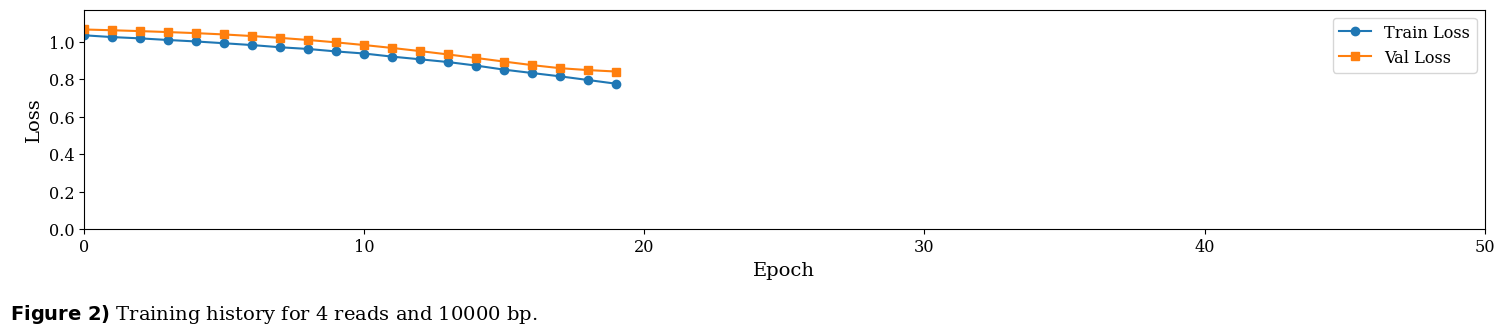

In [ ]:
plt.figure(figsize=(15, 3))
plt.plot(train_losses, label="Train Loss", marker="o")
plt.plot(val_losses, label="Val Loss", marker="s")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.ylim(0, max(max(train_losses), max(val_losses)) * 1.1)
plt.xlim(0, 50)
plt.tight_layout()
plotter.add_caption(
    f"Training history for {simulation_params.n_samples} reads and {simulation_params.length_bp} bp."
)

## 13. Evaluate on test set
Compute metrics on the held-out test data; handle padding and support sklearn or numpy fallbacks.

In [ ]:
# Load best model
model.load_state_dict(torch.load(model_filename))

# Evaluate on test set
model.eval()
test_loss, test_preds, test_labels = validate(
    model, test_loader, criterion_weighted, device
)

print(f"Test Loss: {test_loss:.4f}")

# Compute metrics
all_preds_flat = np.concatenate(test_preds).ravel()
all_labels_flat = np.concatenate(test_labels).ravel()

# Remove padding positions
valid_mask = all_labels_flat >= 0
all_preds_flat = all_preds_flat[valid_mask]
all_labels_flat = all_labels_flat[valid_mask]

# Threshold at 0.3 (lower for imbalanced data with weighted loss)
predictions_binary = (all_preds_flat >= 0.3).astype(int)


# Metrics: try sklearn, fallback to numpy implementations if missing
try:
    from sklearn.metrics import (
        accuracy_score,
        precision_score,
        recall_score,
        f1_score,
        roc_auc_score,
    )

    sklearn_available = True
except Exception as e:
    sklearn_available = False
    import warnings

    warnings.warn(
        "scikit-learn not installed; using numpy fallback for basic metrics. Install with: pip install scikit-learn"
    )

    def accuracy_score(y_true, y_pred):
        y_true = np.asarray(y_true)
        y_pred = np.asarray(y_pred)
        return float((y_true == y_pred).mean())

    def precision_score(y_true, y_pred, zero_division=0):
        y_true = np.asarray(y_true)
        y_pred = np.asarray(y_pred)
        tp = int(((y_true == 1) & (y_pred == 1)).sum())
        fp = int(((y_true == 0) & (y_pred == 1)).sum())
        denom = tp + fp
        if denom == 0:
            return float(zero_division)
        return float(tp / denom)

    def recall_score(y_true, y_pred, zero_division=0):
        y_true = np.asarray(y_true)
        y_pred = np.asarray(y_pred)
        tp = int(((y_true == 1) & (y_pred == 1)).sum())
        fn = int(((y_true == 1) & (y_pred == 0)).sum())
        denom = tp + fn
        if denom == 0:
            return float(zero_division)
        return float(tp / denom)

    def f1_score(y_true, y_pred, zero_division=0):
        p = precision_score(y_true, y_pred, zero_division)
        r = recall_score(y_true, y_pred, zero_division)
        if (p + r) == 0:
            return float(zero_division)
        return 2 * (p * r) / (p + r)

    def roc_auc_score(y_true, y_score):
        y_true = np.asarray(y_true)
        y_score = np.asarray(y_score)
        # require both classes present
        if len(np.unique(y_true)) < 2:
            return float("nan")
        # Sort scores descending
        desc = np.argsort(-y_score)
        y_true_sorted = y_true[desc]
        # cumulative true/false positives
        tp = np.cumsum(y_true_sorted == 1)
        fp = np.cumsum(y_true_sorted == 0)
        tp_total = tp[-1]
        fp_total = fp[-1]
        if tp_total == 0 or fp_total == 0:
            return float("nan")
        tpr = np.concatenate([[0.0], tp / tp_total])
        fpr = np.concatenate([[0.0], fp / fp_total])
        return float(np.trapz(tpr, fpr))


# Calculate metrics
acc = accuracy_score(all_labels_flat, predictions_binary)
prec = precision_score(all_labels_flat, predictions_binary, zero_division=0)
rec = recall_score(all_labels_flat, predictions_binary, zero_division=0)
f1 = f1_score(all_labels_flat, predictions_binary, zero_division=0)
auc = roc_auc_score(all_labels_flat, all_preds_flat)

print(f"\nTest Metrics:")
print(f"  Accuracy:  {acc:.4f}")
print(f"  Precision: {prec:.4f}")
print(f"  Recall:    {rec:.4f}")
print(f"  F1-Score:  {f1:.4f}")
print(f"  ROC-AUC:   {auc:.4f}")

Validating: 100%|██████████| 1/1 [00:00<00:00,  6.90it/s]



Test Loss: 0.7999

Test Metrics:
  Accuracy:  0.5610
  Precision: 0.0117
  Recall:    1.0000
  F1-Score:  0.0231
  ROC-AUC:   0.8088

Test Metrics:
  Accuracy:  0.5610
  Precision: 0.0117
  Recall:    1.0000
  F1-Score:  0.0231
  ROC-AUC:   0.8088


## 14. Save model and config
Persist the best model weights and write the LLM configuration into the shared JSON (alongside simulation parameters).

In [ ]:
# Save model and configuration
model_config = {
    "_vocab_size": 8,
    "_embedding_dim": 16,
    "_hidden_dim": 64,
    "_num_layers": 2,
    "_dropout": 0.3,
}

# Unified config file with two sections: 'simulation' and 'llm'
config_path = model_filename.with_suffix(".json")
if config_path.exists():
    with open(config_path, "r") as f:
        existing_config = json.load(f)
else:
    existing_config = {}

# Preserve any existing sections; update/add the LLM section
existing_config["llm"] = model_config

with open(config_path, "w") as f:
    json.dump(existing_config, f, indent=4)

print("Model and config saved!")
print(f"Config path: {config_path}")
print(f"Config sections: {list(existing_config.keys())}")

Model and config saved!
Config path: data\LLM models\test.json
Config sections: ['simulation', 'llm']


## 15. Load saved model and predict
Reload the trained model and produce dyad probability predictions and visualizations for a new sequence.

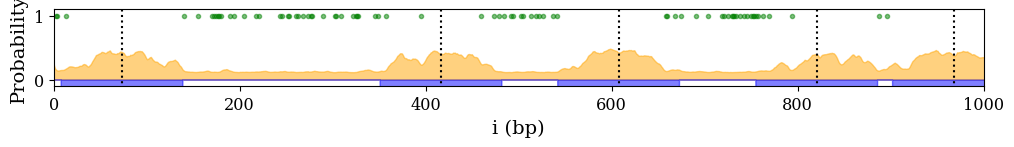

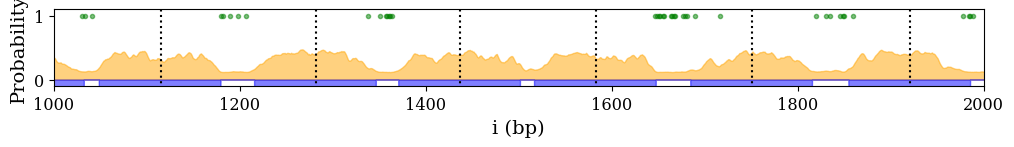

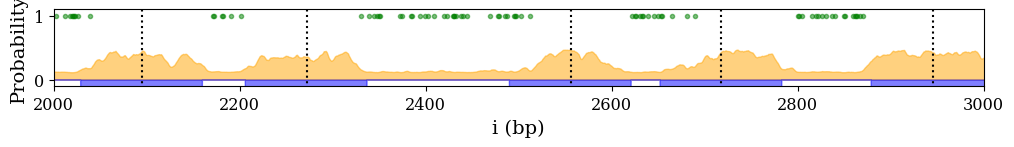

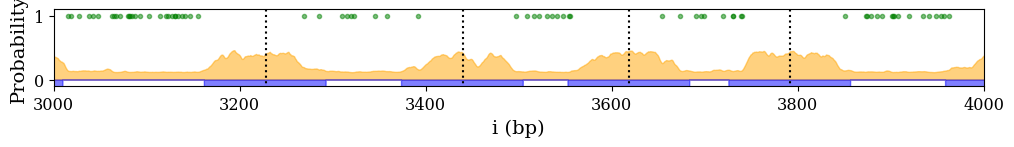

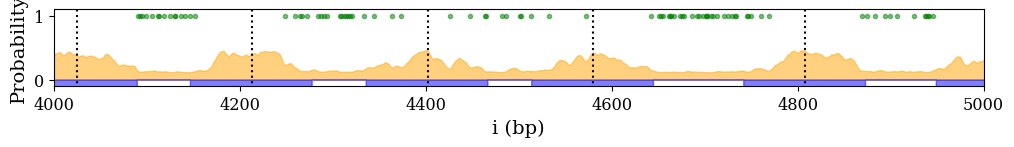

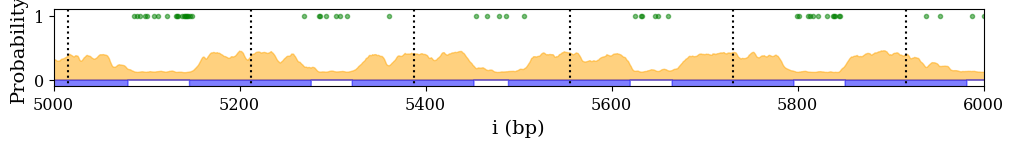

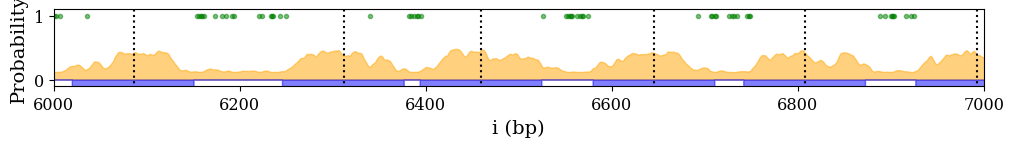

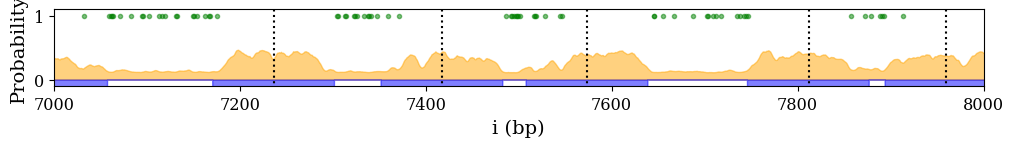

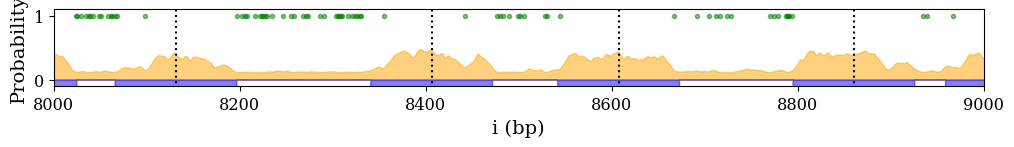

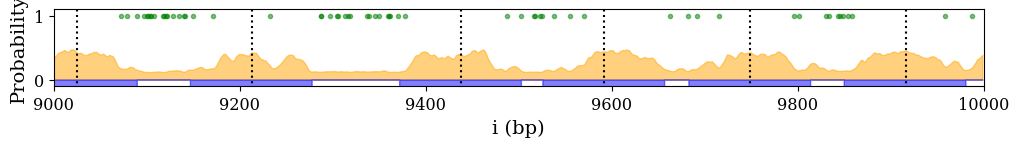

In [ ]:
def predict_dyads(model, encoded_sequence, threshold=0.2, device="cpu"):
    """
    Predict dyad positions for a single sequence.

    Args:
        model: trained DyadPredictor
        encoded_sequence: list/array of integers (0-7)
        threshold: probability threshold for positive class (default 0.5)
        device: torch device

    Returns:
        dyad_positions: list of predicted dyad positions
        probabilities: array of per-position probabilities
    """

    model.eval()
    with torch.no_grad():
        seq_tensor = torch.LongTensor(encoded_sequence).unsqueeze(0).to(device)
        logits = model(seq_tensor)
        probs = torch.sigmoid(logits).squeeze().cpu().numpy()

    dyad_positions = np.where(probs >= threshold)[0].tolist()
    return dyad_positions, probs


# Load config (two-section format: {'simulation': {...}, 'llm': {...}})
config_path = model_filename.with_suffix(".json")
with open(config_path, "r") as f:
    config = json.load(f)

llm_cfg = config.get("llm", {})

# Create model from LLM section (keys are prefixed with '_')
loaded_model = DyadPredictor(
    **{k[1:]: v for k, v in llm_cfg.items() if k.startswith("_")}
)
loaded_model.load_state_dict(torch.load(model_filename))
loaded_model = loaded_model.to(device)
loaded_model.eval()

# Generate a new sample using read_simulation_results
# Get a sample from the existing HDF5 file (index 0)
dyad_positions_sample, encoded_seq_sample, methylated_seq = read_simulation_results(data_filename, 0)

new_seq = encoded_seq_sample

dyads, probs = predict_dyads(loaded_model, new_seq, device=device)

index = np.arange(len(new_seq))
nucs = np.zeros_like(index)
nucs[dyad_positions_sample] = 1.0

for i in dyad_positions_sample:
    nucs[i - 65 : i + 65] = -1  # highlight nucleosome region

n_plots = 10
for i in range(n_plots):
    plt.figure(figsize=(12, 1))
    plt.xlabel("i (bp)")

    plt.vlines(
        dyad_positions_sample, ymin=-1, ymax=2, color="black", linestyles="dotted", alpha=1
    )
    plt.fill_between(
        index, probs, label="Predicted Dyad Probability", color="orange", alpha=0.5
    )
    plt.fill_between(index, nucs, color="blue", alpha=0.5, label="True Dyad Positions")

    methylations = np.zeros_like(index)*np.nan
    methylations[index[new_seq > 4]] = 1
    plt.plot(
        index,
        methylations,
        "o",
        label="methylations",
        color="green",
        alpha=0.5,
        fillstyle="full",
        markersize=3,
    )

    plt.xlim(i * len(index) // n_plots, (i + 1) * len(index) // n_plots)
    plt.ylabel("Probability")
    plt.ylim(-0.1, 1.1)

    # plt.tight_layout
    plt.show()